# **Setup & Dependencies**

In [14]:
import os
import math
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Loading & Frame Building**

In [15]:
def load_and_preprocess_data(filepath, frame_size=100):
    data = pd.read_excel(filepath)

    # Normalize selected accelerometer columns
    acc_cols = ['right acceleration X[g]', 'right acceleration Y[g]', 'right acceleration Z[g]']
    scaler = StandardScaler()
    data[acc_cols] = scaler.fit_transform(data[acc_cols])

    labels = data['label'].values
    class_weights = compute_class_weights(labels)

    all_frames, all_labels = [], []

    # Segment data into fixed-size frames
    for i in range(0, len(data), frame_size):
        segment = data.iloc[i:i + frame_size]
        frame = segment[acc_cols].values.flatten()
        label = np.bincount(segment['label']).argmax()  # Majority label for the frame
        all_frames.append(frame)
        all_labels.append(label)

    return np.array(all_frames), np.array(all_labels), class_weights, data


def build_a_frame_dict(all_frames, all_labels):
    a_frame = {i: [] for i in range(all_frames.shape[1])}
    a_frame['label'] = []

    for frame, label in zip(all_frames, all_labels):
        for i, val in enumerate(frame):
            a_frame[i].append(val)
        a_frame['label'].append(label)

    return pd.DataFrame(a_frame)


def compute_class_weights(labels):
    label_counts = np.bincount(labels)
    total = len(labels)

    # Weight = total / (2 * count) to handle class imbalance
    weights = [total / (2 * c) if c > 0 else 0 for c in label_counts]
    return torch.tensor(weights, dtype=torch.float32)


# **Dataset & DataLoader**

In [16]:
class IMUDataset(Dataset):
    def __init__(self, x, y):
        # Reshape input to (samples, sequence_length=100, features=3)
        self.X = torch.tensor(x, dtype=torch.float32).reshape(-1, 100, 3)
        self.Y = torch.tensor(y, dtype=torch.long).squeeze()


    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


def prepare_dataloaders(df, batch_size=8):
    x = df.iloc[:, :-1].values
    y = df['label'].values

    # Split into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

    train_set = IMUDataset(x_train, y_train)
    val_set = IMUDataset(x_val, y_val)

    return {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
        'val': DataLoader(val_set, batch_size=batch_size, shuffle=False)
    }


In [ ]:
class IMUDataset(Dataset):
    def __init__(self, x, y):
        self.X = torch.tensor(x, dtype=torch.float32).reshape(-1, 100, 3)
        self.Y = torch.tensor(y, dtype=torch.long).squeeze()

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# **Transformer Model**

In [17]:
class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):
        # Compute scaled dot-product attention
        d_k = q.size(-1)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
        attn = self.softmax(scores)
        return torch.matmul(attn, v), attn


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.attn = ScaleDotProductAttention()
        self.qkv_proj = nn.Linear(d_model, d_model * 3)  # Combine Q, K, V projections
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv_proj(x).reshape(B, T, self.n_head, -1).permute(2, 0, 1, 3)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        out, _ = self.attn(q, k, v)
        out = out.permute(1, 2, 0, 3).reshape(B, T, C)
        return self.out_proj(out)


class LayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = 1e-6

    def forward(self, x):
        # Normalize across the last dimension
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim, drop_prob=0.2):
        super().__init__()

        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.Linear(hidden_dim, d_model)
        )

    def forward(self, x):
        return self.ffn(x)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.2, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Precompute sinusoidal positional encodings
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, drop_prob=0.2):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model, ffn_hidden)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        # Multi-head self-attention with residual and norm
        _x = x
        x = self.attn(x)
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        # Feed-forward network with residual and norm
        _x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + _x)

        return x


class Encoder(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, n_layers, drop_prob=0.2):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_head, ffn_hidden,  drop_prob=drop_prob)
            for _ in range(n_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TransformerModel(nn.Module):
    def __init__(self, d_model=64, n_head=2, n_layers=2, seq_len=100, ffn_hidden=128, num_classes=2, drop_prob=0.2):
        super().__init__()
        self.input_proj = nn.Linear(3, d_model)  # Project 3D input to model dimension
        self.pos_enc = PositionalEncoding(d_model)
        self.encoder = Encoder(d_model, n_head, ffn_hidden, n_layers, drop_prob)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * seq_len, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        return self.classifier(x)


In [ ]:
# ----- Cross-Validation -----
def cross_validate_model(frames, labels, num_epochs=100, batch_size=8, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    all_fold_results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for fold_idx, (train_index, val_index) in enumerate(kf.split(frames)):
        print(f"\nTraining and Evaluating Fold {fold_idx + 1}/{k_folds}...")

        x_train, x_val = frames[train_index], frames[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        train_set = IMUDataset(x_train, y_train)
        val_set = IMUDataset(x_val, y_val)

        dataloaders = {
            'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
            'val': DataLoader(val_set, batch_size=batch_size, shuffle=False)
        }

        model = TransformerModel(num_classes=len(np.unique(labels))).to(device)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)

        trained_model, history = train_model(
            model,
            dataloaders,
            optimizer,
            class_weights=None,
            num_epochs=num_epochs,
            patience=10
        )

        fold_metrics = evaluate_model(trained_model, dataloaders['val'])

        for metric_name, metric_value in fold_metrics.items():
            all_fold_results[metric_name].append(metric_value)

        print(f"Fold {fold_idx + 1} - Metrics: {fold_metrics}")

    print("\nAverage Performance Across All Folds:")
    for metric_name, metric_values in all_fold_results.items():
        mean_value = np.mean(metric_values)
        std_value = np.std(metric_values)
        print(f"{metric_name.capitalize()} - Mean: {mean_value:.4f}, Std: {std_value:.4f}")

    return all_fold_results



# ----- Evaluation -----
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }

# ----- Plot Cross-validation Metrics -----
def plot_cv_metrics(cv_results):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    plt.figure(figsize=(12, 8))

    for idx, metric in enumerate(metrics):
        plt.subplot(3, 2, idx+1)
        plt.plot(range(1, len(cv_results[metric]) + 1), cv_results[metric], marker='o')
        plt.title(f"{metric.capitalize()} Across Folds")
        plt.xlabel('Fold')
        plt.ylabel(metric.capitalize())
        plt.grid(True)

    plt.tight_layout()
    plt.show()


# **Training & Evaluation**

In [19]:
def calc_loss_and_score(outputs, targets, class_weights, metrics):
    # Cross-entropy loss with class weights
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    loss = loss_fn(outputs, targets)

    metrics['loss'].append(loss.item())
    _, preds = torch.max(outputs, 1)
    metrics['correct'] += (preds == targets).sum().item()
    metrics['total'] += targets.size(0)

    return loss


def train_model(model, dataloaders, optimizer, class_weights, patience=10, num_epochs = 100):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train': [], 'val': []}
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            metrics = {'loss': [], 'correct': 0, 'total': 0}

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss_and_score(outputs, labels, class_weights, metrics)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            epoch_loss = np.mean(metrics['loss'])
            epoch_acc = 100 * metrics['correct'] / metrics['total']
            history[phase].append((epoch_loss, epoch_acc))

            # Save model if it improves on validation loss
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    print(" Best model updated!")
                else:
                    epochs_no_improve += 1


            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs!")
                break

    model.load_state_dict(best_model_wts)
    return model, history

# def evaluate_and_plot_confusion_matrix(model, dataloader, class_names=None, save_path=None):
def evaluate_and_plot_confusion_matrix(model=None, dataloader=None, all_preds=None, all_labels=None, class_names=None, save_path=None):
  if dataloader:
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute performance metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("\nFinal Validation Metrics:")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall   : {rec * 100:.2f}%")
    print(f"F1 Score : {f1 * 100:.2f}%")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to: {save_path}")
    plt.show()


def plot_metrics(history):
    # Unpack history
    epochs = range(1, len(history['val']) + 1)
    train_loss, train_acc = zip(*history['train'])
    val_loss, val_acc = zip(*history['val'])

    # Plot loss and accuracy trends
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    #plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, train_loss[:len(epochs)], label='Train')
    plt.plot(epochs, val_loss, label='Val')
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    #plt.plot(epochs, train_acc, label='Train')
    plt.plot(epochs, train_acc[:len(epochs)], label='Train')
    plt.plot(epochs, val_acc, label='Val')
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.show()


In [ ]:
def plot_metrics(fold_histories):
    """
    Plots training and validation loss/accuracy across all folds.

    Args:
        fold_histories: List of dicts (one per fold), each with:
                        {'train': [(loss, acc), ...], 'val': [(loss, acc), ...]}
    """
    num_folds = len(fold_histories)
    max_epochs = max(len(h['train']) for h in fold_histories)

    # Prepare averaged metrics
    avg_train_loss = np.zeros(max_epochs)
    avg_val_loss = np.zeros(max_epochs)
    avg_train_acc = np.zeros(max_epochs)
    avg_val_acc = np.zeros(max_epochs)

    plt.figure(figsize=(14, 6))

    # Plot per fold
    for fold_idx, history in enumerate(fold_histories):
        train_loss, train_acc = zip(*history['train'])
        val_loss, val_acc = zip(*history['val'])

        epochs = range(1, len(train_loss) + 1)

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, linestyle='--', alpha=0.6, label=f'Train Fold {fold_idx + 1}')
        plt.plot(epochs, val_loss, linestyle='-', alpha=0.6, label=f'Val Fold {fold_idx + 1}')

        # Accumulate for average
        for i, (tl, vl, ta, va) in enumerate(zip(train_loss, val_loss, train_acc, val_acc)):
            avg_train_loss[i] += tl
            avg_val_loss[i] += vl
            avg_train_acc[i] += ta
            avg_val_acc[i] += va

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, linestyle='--', alpha=0.6, label=f'Train Fold {fold_idx + 1}')
        plt.plot(epochs, val_acc, linestyle='-', alpha=0.6, label=f'Val Fold {fold_idx + 1}')

    # Compute mean across folds
    avg_train_loss /= num_folds
    avg_val_loss /= num_folds
    avg_train_acc /= num_folds
    avg_val_acc /= num_folds

    # Plot average curves
    epochs = range(1, max_epochs + 1)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, avg_train_loss, color='black', linewidth=2, label='Avg Train')
    plt.plot(epochs, avg_val_loss, color='blue', linewidth=2, label='Avg Val')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, avg_train_acc, color='black', linewidth=2, label='Avg Train')
    plt.plot(epochs, avg_val_acc, color='blue', linewidth=2, label='Avg Val')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()


# **Run Everything**


Epoch 1/100
------------------------------
Train Loss: 0.6622 | Accuracy: 61.23%
 Best model updated!
Val Loss: 0.6424 | Accuracy: 65.20%

Epoch 2/100
------------------------------
Train Loss: 0.6121 | Accuracy: 67.07%
Val Loss: 0.6532 | Accuracy: 67.71%

Epoch 3/100
------------------------------
Train Loss: 0.5885 | Accuracy: 70.29%
 Best model updated!
Val Loss: 0.6173 | Accuracy: 66.93%

Epoch 4/100
------------------------------
Train Loss: 0.5596 | Accuracy: 72.79%
 Best model updated!
Val Loss: 0.6005 | Accuracy: 68.81%

Epoch 5/100
------------------------------
Train Loss: 0.5613 | Accuracy: 71.11%
Val Loss: 0.6299 | Accuracy: 69.44%

Epoch 6/100
------------------------------
Train Loss: 0.5374 | Accuracy: 73.62%
 Best model updated!
Val Loss: 0.5993 | Accuracy: 69.59%

Epoch 7/100
------------------------------
Train Loss: 0.5064 | Accuracy: 74.72%
 Best model updated!
Val Loss: 0.5599 | Accuracy: 70.85%

Epoch 8/100
------------------------------
Train Loss: 0.4805 | Accu

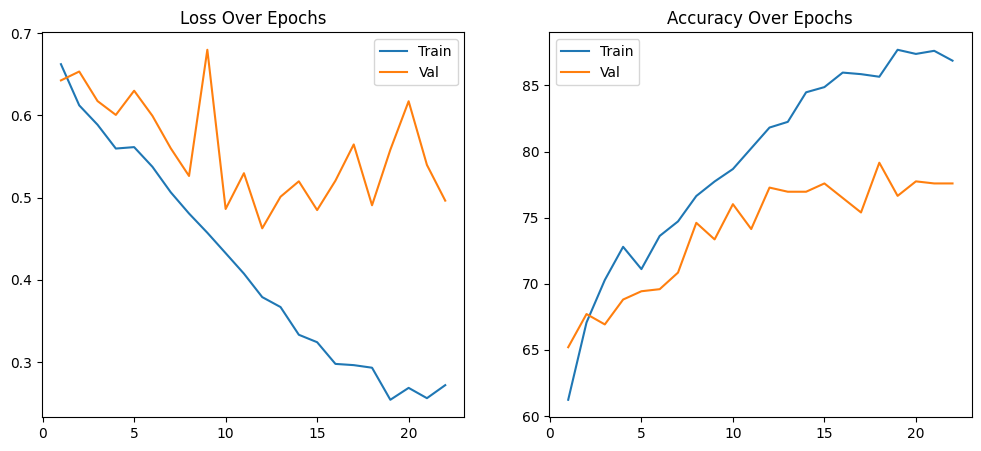


Final Validation Metrics:
Accuracy : 77.27%
Precision: 78.16%
Recall   : 77.27%
F1 Score : 77.43%
Confusion matrix saved to: /content/drive/MyDrive/IMU/confusion_matrix.png


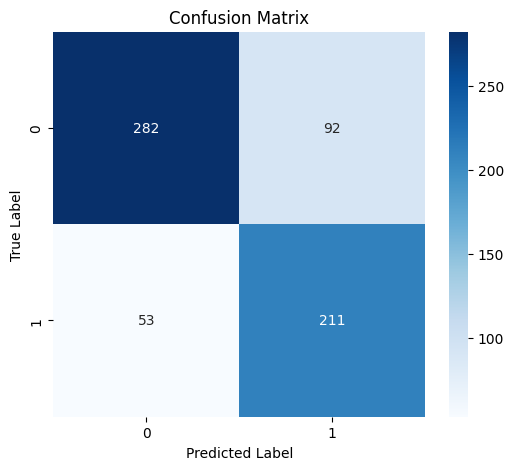

In [20]:
# Load and preprocess raw IMU data
file_path = "/content/drive/MyDrive/IMU/combined_data.xlsx"
frames, labels, class_weights, raw_data = load_and_preprocess_data(file_path)

# Convert framed data into a DataFrame format for training
df = build_a_frame_dict(frames, labels)
num_classes = len(np.unique(labels))

# Prepare dataloaders
dataloaders = prepare_dataloaders(df, batch_size=8)

# Initialize model and optimizer
model = TransformerModel(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Train the model
trained_model, history = train_model(
    model,
    dataloaders,
    optimizer,
    class_weights,
    num_epochs=100,
    patience=10,
)

# Plot training/validation metrics
plot_metrics(history)

# Evaluate final model performance and save confusion matrix
evaluate_and_plot_confusion_matrix(
    trained_model,
    dataloaders['val'],
    class_names=[str(i) for i in range(num_classes)],
    save_path="/content/drive/MyDrive/IMU/confusion_matrix.png"
)

# Save the trained model
torch.save(trained_model.state_dict(), "/content/drive/MyDrive/IMU/transformer_model_gaitAnalysis.pth")
